# **LC25000 -Lung Cancer Classification Using Custom CNN Model**

In [23]:
import keras
print(keras.__version__)

2.12.0


**Import Libraries**

In [24]:
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, Dropout, Add
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense
from keras.utils import np_utils
#from keras.initializers import glorot_uniform
from keras import backend as K

import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [25]:
import cv2
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import math

In [26]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (80,80))
            images.append(img)
            
    return np.array(images)

In [27]:
benign = load_images('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n')
mal_aca = load_images('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca')
mal_scc = load_images('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc')

In [28]:
print(f"Number of images for every class: BENIGN {benign.shape[0]}, ADENOCARCINOMAS {mal_aca.shape[0]}, SQUAMOS CELL CARCINOMAS {mal_scc.shape[0]}.")

Number of images for every class: BENIGN 5000, ADENOCARCINOMAS 5000, SQUAMOS CELL CARCINOMAS 5000.


In [29]:
print(f"Images shape: {benign[0].shape}.")

Images shape: (80, 80, 3).


In [30]:
# plot the first image for every class using subplot

In [31]:
samples = np.concatenate((benign, mal_aca, mal_scc))
labels = np.array(benign.shape[0] * [0] + mal_aca.shape[0] * [1] + mal_scc.shape[0] * [2])

In [32]:
print(f"Samples shape check: {samples.shape}.")
print(f"Labels shape check: {labels.shape}.")

Samples shape check: (15000, 80, 80, 3).
Labels shape check: (15000,).


In [33]:
indices = np.arange(samples.shape[0])
np.random.shuffle(indices)

samples = samples[indices]
labels = labels[indices]

# normalize pictures
samples = samples.astype('float32') / 255

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size = 0.2)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)

In [35]:
Y_train = np_utils.to_categorical(y_train, 3)
Y_val = np_utils.to_categorical(y_val, 3)
Y_test = np_utils.to_categorical(y_test, 3)

print(Y_train[0])
print(f"Y_train shape after one hot encoding: {Y_val.shape}")
print(f"Y_train shape after one hot encoding: {X_val.shape}")

[0. 0. 1.]
Y_train shape after one hot encoding: (1500, 3)
Y_train shape after one hot encoding: (1500, 80, 80, 3)


# - Custom Model

In [36]:
def base_model(input_shape=(80,80,3) ,classes=3):
    '''
    CNN base model with 4 hidden layers (3 conv and one fully connected)
    '''
    inputs = Input(shape=input_shape)

    X = Conv2D(32, 3, 3, activation='relu')(inputs)
    X = MaxPooling2D(pool_size=(2,2))(X)

    X = Conv2D(64, 3, 3, activation='relu')(X)
    X = MaxPooling2D(pool_size=(2,2))(X)
    X = Dropout(0.2)(X)

    X = Conv2D(128, 3, 3, activation='relu', padding='same')(X)
    X = MaxPooling2D(pool_size=(2,2), padding='same')(X)
    X = Dropout(0.2)(X)

    X = Flatten()(X)
    X = Dense(256, activation='relu')(X)
    outputs = Dense(classes, activation='softmax')(X)

    model = Model(inputs, outputs)
    
    return model

In [37]:
model = base_model(input_shape=(80,80,3),classes=3)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 64)         0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 2, 2, 64)          0   

In [38]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

history = model.fit(X_train, Y_train, batch_size=64, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10
188/188 [==============================] - 7s 29ms/step - loss: 0.4704 - accuracy: 0.7763 - val_loss: 0.3007 - val_accuracy: 0.8680
Epoch 2/10
188/188 [==============================] - 5s 29ms/step - loss: 0.2913 - accuracy: 0.8816 - val_loss: 0.2936 - val_accuracy: 0.8707
Epoch 3/10
188/188 [==============================] - 5s 27ms/step - loss: 0.2475 - accuracy: 0.8997 - val_loss: 0.1852 - val_accuracy: 0.9320
Epoch 4/10
188/188 [==============================] - 5s 27ms/step - loss: 0.2309 - accuracy: 0.9058 - val_loss: 0.1768 - val_accuracy: 0.9347
Epoch 5/10
188/188 [==============================] - 5s 27ms/step - loss: 0.2047 - accuracy: 0.9158 - val_loss: 0.1680 - val_accuracy: 0.9347
Epoch 6/10
188/188 [==============================] - 5s 27ms/step - loss: 0.1892 - accuracy: 0.9233 - val_loss: 0.1662 - val_accuracy: 0.9340
Epoch 7/10
188/188 [==============================] - 5s 27ms/step - loss: 0.1772 - accuracy: 0.9306 - val_loss: 0.1687 - val_accuracy: 0.9380

/tmp/ipykernel_158/3116035815.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


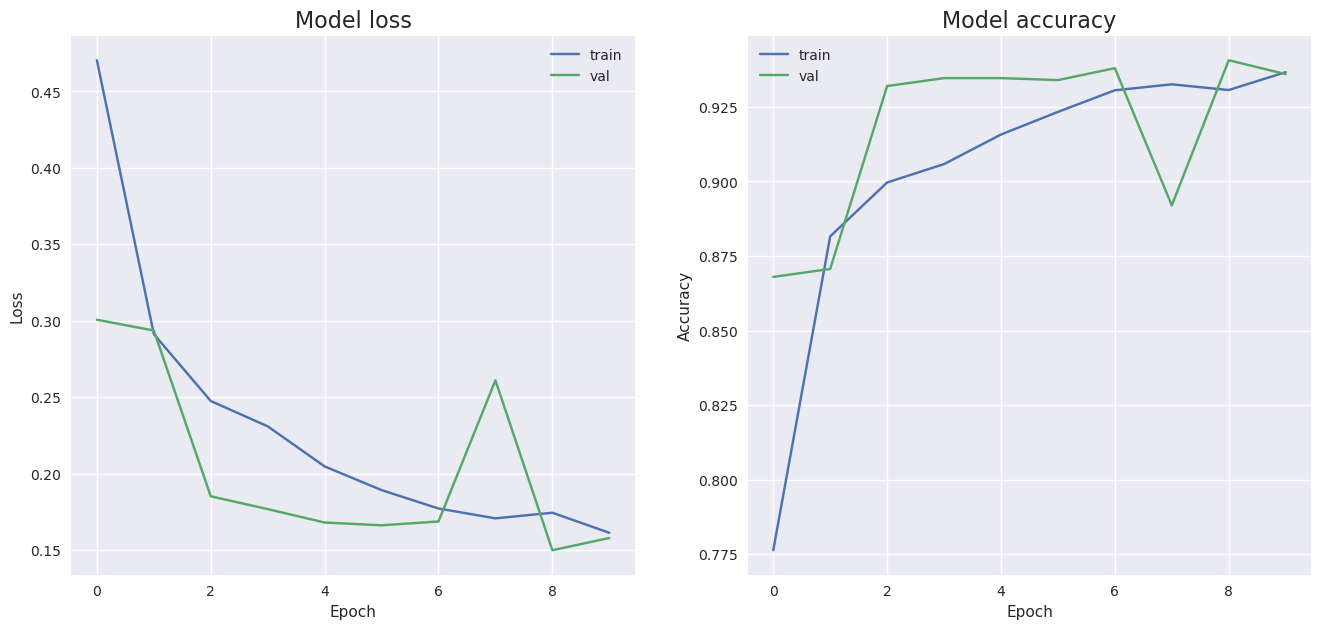

In [39]:
plt.style.use('seaborn')
plt.figure(figsize=(16,7))

plt.subplot(1,2,1)
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model loss', fontsize=16)  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model accuracy', fontsize=16)  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'])

plt.show()

In [40]:
y_pred_test = model.predict(X_test, verbose=1)
y_pred_train = model.predict(X_train, verbose=1)

# conversion to one hot encoding
#y_pred_test = (y_pred_test > 0.5).astype("int32")
#y_pred_train = (y_pred_train > 0.5).astype("int32")

# convert it to numerical classes
y_pred_test = np.argmax(y_pred_test, axis=1)
y_pred_train = np.argmax(y_pred_train, axis=1)

score_test = model.evaluate(X_test, Y_test)
print(f"Train accuracy: {history.history['accuracy'][-1]:.3f}")
print(f"Validation accuracy: {history.history['val_accuracy'][-1]:.3f}")
print(f"Test accuracy: {score_test[1]:.3f}")

47/47 [==============================] - 0s 6ms/step - loss: 0.1759 - accuracy: 0.9240
Train accuracy: 0.937
Validation accuracy: 0.936
Test accuracy: 0.924


<Axes: >

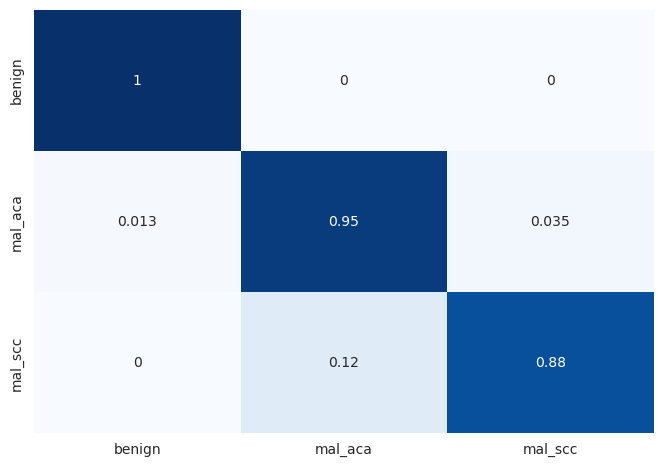

In [41]:
label_names = ['benign', 'mal_aca', 'mal_scc']


confmat = confusion_matrix(y_train, y_pred_train, normalize='true')
sn.heatmap(confmat, annot=True, cmap='Blues', cbar=False, 
           xticklabels=label_names, yticklabels=label_names)

In [42]:
from sklearn.metrics import confusion_matrix, classification_report


# Classification report for training set
classification_report_train = classification_report(y_train, y_pred_train, target_names=label_names)

# Classification report for testing set
classification_report_test = classification_report(y_test, y_pred_test, target_names=label_names)

print("Training Set Classification Report:\n")
print(classification_report_train)

print("Testing Set Classification Report:\n")
print(classification_report_test)

Training Set Classification Report:

              precision    recall  f1-score   support

      benign       0.99      1.00      0.99      3990
     mal_aca       0.88      0.95      0.92      3967
     mal_scc       0.96      0.88      0.92      4043

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.95      0.94      0.94     12000

Testing Set Classification Report:

              precision    recall  f1-score   support

      benign       0.98      1.00      0.99       500
     mal_aca       0.85      0.95      0.89       510
     mal_scc       0.96      0.82      0.89       490

    accuracy                           0.92      1500
   macro avg       0.93      0.92      0.92      1500
weighted avg       0.93      0.92      0.92      1500



In [43]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Get true classes for test and train datasets
y_true_test = np.argmax(Y_test, axis=1)
y_true_train = np.argmax(Y_train, axis=1)

# Calculate precision, recall, and F1 score for test and train datasets
precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(y_true_test, y_pred_test, average='weighted')
precision_train, recall_train, f1_score_train, _ = precision_recall_fscore_support(y_true_train, y_pred_train, average='weighted')

# Print the results
print("Test set metrics:")
print(f"Precision: {precision_test:.3f}")
print(f"Recall: {recall_test:.3f}")
print(f"F1 Score: {f1_score_test:.3f}")

print("\nTrain set metrics:")
print(f"Precision: {precision_train:.3f}")
print(f"Recall: {recall_train:.3f}")
print(f"F1 Score: {f1_score_train:.3f}")



Test set metrics:
Precision: 0.928
Recall: 0.924
F1 Score: 0.924

Train set metrics:
Precision: 0.945
Recall: 0.943
F1 Score: 0.943


**Mistakes**

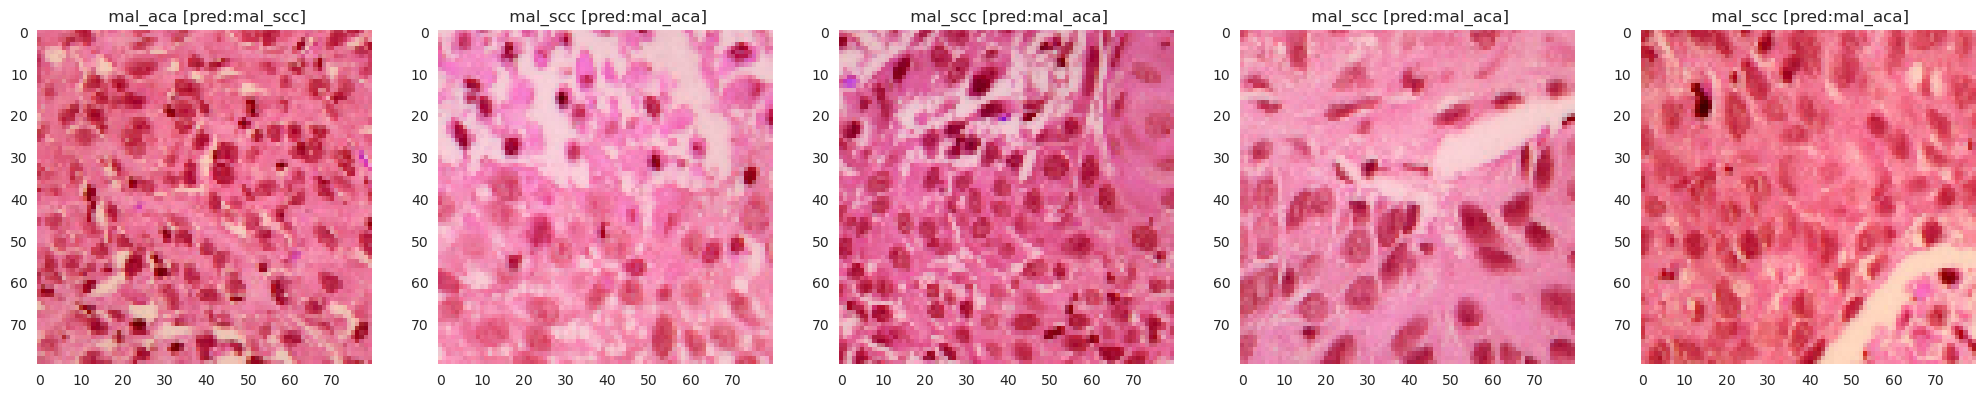

In [44]:
mistakes = np.where(y_pred_train != y_train)[0]

n = 5

plt.figure(figsize=(5*n,5))

# get 5 random false negatives
for i, val in enumerate(np.random.choice(mistakes, n)):

    plt.subplot(1,n,i+1)
    plt.imshow(X_train[val])
    plt.title(f" {label_names[y_train[val]]} [pred:{label_names[y_pred_train[val]]}]", fontsize=12)
    plt.grid(None)